In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import io 
import base64
from PIL import Image
from ast import literal_eval
import sys
import os
import statsmodels.api as sm

J_PATH = True
if J_PATH: 
    BASE = "/Users/johnathansun/Documents/"
else: 
    BASE = "/Users/victoriali/Documents/GitHub/"

sys.path.append(os.path.abspath('..'))

from utils import experiment_to_prompt
from utils import round_to_significant_figures

In [156]:
def generate_parabolas(total_points, extra_points, seed):
    """
    Generate sample points along a downward-opening parabola y = -a x^2 + b x.
    Samples are uniformly spaced in x from 0 to x_max such that
    - The vertex at x_v = b/(2a) falls on the (total_points - extra_points)-th point (0-indexed).
    - There are extra_points samples beyond the vertex.

    Parameters:
    total_points (int): Total number of (x, y) pairs to return.
    extra_points (int): Number of points beyond the vertex.

    Returns:
    x (np.ndarray): Array of x-values, shape (total_points,).
    y (np.ndarray): Array of y-values, shape (total_points,).
    """
    # Random parabola parameters

    np.random.seed(seed)
    a = np.random.uniform(0, 1)
    b = np.random.uniform(0, 10)

    # Compute the vertex location
    x_vertex = b / (2 * a)

    if extra_points >= total_points:
        raise ValueError("extra_points must be less than total_points")

    # Determine the index (0-based) at which the vertex should occur
    idx_vertex = total_points - extra_points - 1

    # Compute maximum x so that idx_vertex corresponds exactly to x_vertex
    x_max = x_vertex * (total_points - 1) / idx_vertex

    # Generate uniformly spaced x-values
    x = np.linspace(0, x_max, total_points)
    y = -a * x**2 + b * x

    x_offset = np.random.uniform(0, 10)
    y_offset = np.random.uniform(0, 10)

    x_noise = np.random.normal(0, np.mean(x) / 150, len(x))
    y_noise = np.random.normal(0, np.mean(y) / 150, len(y))

    x += x_offset + x_noise
    y += y_offset + y_noise

    params = {
        'a' : a,
        'b' : b,
        'x_offset' : x_offset,
        'y_offset' : y_offset,
        'x_noise' : x_noise,
        'y_noise' : y_noise
    }

    return x, y, params


def hash_image(df):
    fig, ax = plt.subplots()
    ax.scatter(df['x'], df['y'])

    # Save the figure to an in-memory bytes buffer in PNG format
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)  # Close the figure to free resources
    buf.seek(0)     # Rewind the buffer to the beginning

    # Convert the image in the buffer to a base64 encoded string
    img_bytes = buf.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    return img_base64

def unhash_image(img_base64):

    # decode pic_hash to png
    # Step 1: Decode the base64 hash back to bytes
    pic_bytes = base64.b64decode(img_base64)

    # Step 2: Convert bytes to an image using PIL
    image = Image.open(io.BytesIO(pic_bytes))

    return image

In [157]:
def generate_deceptive_nonlinearity(x, y, y_noise, seed=None):
    """
    Fit a straight line to (x, y), then return x and the
    model’s predictions perturbed by a little Gaussian noise.
    """
    # make sure we’re working with numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()

    # reproducible noise
    np.random.seed(seed)

    # design matrix with intercept
    X = sm.add_constant(x)           # shape (n_samples, 2)

    # fit OLS: endog=y, exog=X
    model   = sm.OLS(y, X)
    results = model.fit()

    # get clean predictions
    y_pred = results.predict(X)      # intercept + slope*x

    y_noisy = y_pred + y_noise

    return x, y_noisy

In [158]:
df_lst = []

for i in range(100):
    # choose randomly between 3 5 7 and 9
    # extra_points = np.random.choice([3, 5, 7, 9])
    extra_points = 9
    x, y, y_noise = generate_parabolas(20, extra_points, i)
    x, y_deceptive = generate_deceptive_nonlinearity(x, y, y_noise, i)
    df_lst.append(pd.DataFrame({'x': x, 'y': y, 'y_deceptive': y_deceptive}))

TypeError: unsupported operand type(s) for +: 'float' and 'dict'

In [160]:
# plot in 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(df_lst[i]['x'], df_lst[i]['y'])
    ax.scatter(df_lst[i]['x'], df_lst[i]['y_deceptive'])
    ax.set_title(f'Parabola {i+1}')
plt.tight_layout()
plt.show()
plt.suptitle('Extra Points = 9')

IndexError: list index out of range

Error in callback <function flush_figures at 0x16783e160> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [161]:
final_df = pd.DataFrame(columns=['x', 'y', 'img_b64', 'img_deceptive', 'extra_points', 'params', 'seed'])

In [162]:
# for scale in [1, 100, 10000]:

seed = 0
scale = 1

for extra_points in [3, 5, 7, 9]:
    for _ in range(100):

        total_points = 20

        x, y, params = generate_parabolas(total_points, extra_points, seed)

        df = pd.DataFrame({'x': x, 'y': y})

        y_noise = params['y_noise']
        x, y_deceptive = generate_deceptive_nonlinearity(x, y, y_noise, seed)

        seed += 1

        deceptive_df = pd.DataFrame({'x': x, 'y': y_deceptive})

        for el in [df, deceptive_df]:
            el['x'] = el['x'] * scale
            el['y'] = el['y'] * scale
            el['x'] = round_to_significant_figures(el['x'], 4)
            el['y'] = round_to_significant_figures(el['y'], 4)
        
        to_add = {
            'x': [df['x'].tolist()],
            'y': [df['y'].tolist()],
            'img_b64': hash_image(df),
            'img_deceptive': hash_image(deceptive_df),
            'extra_points': extra_points,
            'params': [params],
            'scale': scale,
            'seed': seed
        }

        final_df = pd.concat([final_df, pd.DataFrame(to_add)])

In [188]:
final_df.to_csv('input_dataframe.csv', index=False)

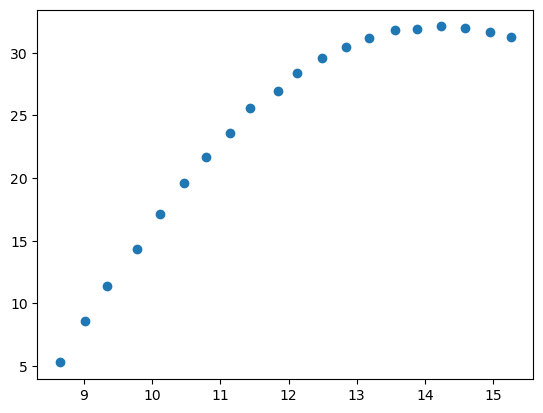

In [186]:
test_row = final_df[final_df['extra_points'] == 3].iloc[8]
unhash_image(test_row['img_b64'])

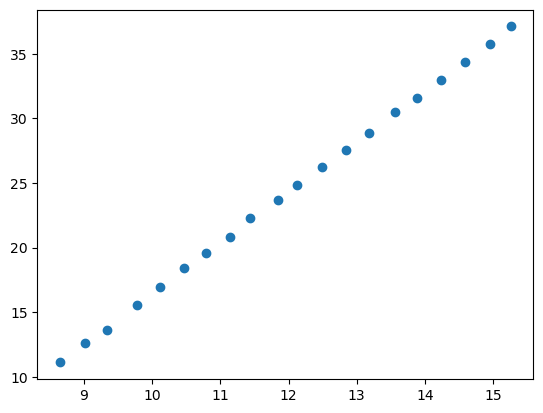

In [187]:
unhash_image(test_row['img_deceptive'])